# CW06 - GUI paper exploration 6 - U-Net densities

Discard: Explorative work

In [1]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch
import swyft

## Model

In [342]:
N = 20  # Number of data bins
SIGMA = 0.1  # Measurement uncertainty

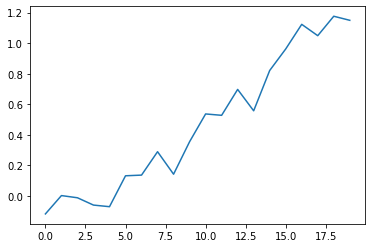

In [343]:
# Noise-free model
NPAR = 4

# Model and reference parameters
def spec(a, b, c, d, LW = 3.3):
    x = np.linspace(0, 10, N)
    y_bg = a+x*b
    y_sig = c*stats.norm.pdf(x, d, LW)
    return y_bg + y_sig

def model(v):
    x = spec(v[0], v[1], v[2], v[3])
    return dict(x=x)

# Noise model
def noise(sim, v, sigma = SIGMA):
    noise = np.random.randn(N)*sigma
    return dict(x = sim['x'] + noise)

v0 = np.array([0.0, 0, 10., 10.])
obs0 = noise(model(v0), v0)
plt.plot(obs0['x'])

# Prior
def transform(u):
    a = scipy.stats.uniform(-1., 1.).ppf(u[0])
    b = scipy.stats.uniform(-1., 1.).ppf(u[1])
    c = scipy.stats.uniform(9., 10.).ppf(u[2])
    d = scipy.stats.uniform(0, 10.).ppf(u[3])
    return np.array([a, b, c, d])

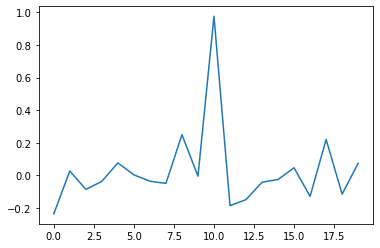

In [371]:
NPAR = 1
NRES = 10

def model(v):
    i = round(v[0]*(N-1))
    x = np.zeros(N)
    x[i] = 1
    return dict(x=x)
    
def noise(sim, v):
    noise = np.random.randn(N)*SIGMA
    return dict(x = sim['x'] + noise)
    
v0 = np.array([0.5])
obs0 = noise(model(v0), v0)
plt.plot(obs0['x'])

# Prior
def transform(u):
    return u

### Zoom in

In [345]:
sim = swyft.Simulator(model, NPAR, dict(x=(N,)))

In [346]:
prior = swyft.Prior(transform, NPAR)

In [347]:
NTRAIN = 1000

In [348]:
store = swyft.MemoryStore(sim)
store.add(NTRAIN, prior)
store.simulate()

Creating new store.
Store: Adding 978 new samples to simulator store.


In [349]:
dataset = swyft.Dataset(NTRAIN, prior, store, simhook = noise)

In [350]:
from swyft.networks.module import Module
from typing import Sequence
from swyft.networks.tail import _get_z_shape, _combine
from swyft.networks.normalization import OnlineNormalizationLayer
from swyft.networks.linear import LinearWithChannel
from torch import nn
from swyft.types import ObsType, SimShapeType

In [351]:
class DefaultHead(Module):
    """Default head network.

    Args:
        sim_shapes: Shape of the simulation data
        online_norm: Perform online normalization of the inputs

    .. note::
        The default head network requires that all simulation components are
        1-dim.  They will be simply concatenated into a single (potentially
        very large) feature vector.  `DefaultHead` should only be used for very
        low-dimensional data.  Almost always custom implementations will lead
        to better results.
    """

    def __init__(self, sim_shapes: SimShapeType, online_norm: bool = True) -> None:
        super().__init__(sim_shapes=sim_shapes, online_norm=online_norm)
        if not all(np.array([len(v) for v in sim_shapes.values()]) == 1):
            raise ValueError(
                "DefaultHead only supports 1-dim data. Please supply custom head network."
            )

        self.n_features = sum([v[0] for k, v in sim_shapes.items()])

        if online_norm:
            self.onl_f = OnlineNormalizationLayer(torch.Size([self.n_features]))
        else:
            self.onl_f = identity

    def forward(self, sim: ObsType) -> torch.Tensor:
        """Forward pass default head network. Concatenate.

        Args:
            sim: Dictionary of tensors with shape (n_batch, m_i)

        Returns:
            f: Feature vectors with shape (n_batch, M), with M = sum_i m_i
        """
        f = torch.cat([value for _, value in sorted(sim.items())], dim=-1)
        #f = self.onl_f(f)
        return f


In [418]:
class DefaultTail(Module):
    def __init__(
        self,
        n_features: int,
        marginals,
        hidden_layers: Sequence[int] = [256, 256, 256],
        p: float = 0.0,
        online_norm: bool = True,
        param_transform=None,
        tail_features: bool = False,
        n_tail_features: int = 2,
    ):
        """Default tail network.

        Args:
            n_features: Length of feature vector.
            marginals: List of marginals to learn.
            hidden_layers: Hidden layer size
            p: Dropout
            online_norm: Online normalization of parameters.
            param_transform: Perform optional parameter transform.
            tail_features: Use tail features.
            n_tail_features: Additional feature extractor network, number of features.

        .. note::
            We find that the default settings for the tail network typically
            give reasonable results, and are almost always enough.  Tuning
            makes only sense when the head network is already close-to optimal.
        """
        super().__init__()
        
        self.unet = UNet3()

    def forward(self, f: torch.Tensor, params) -> torch.Tensor:
        """Forward pass tail network.  Can handle one batch dimension.

        Args:
            f (tensor): feature vectors with shape (n_batch, n_features)
            params (dict): parameter dictionary, with parameter shape (n_batch,)

        Returns:
            lnL (tensor): lnL ratio with shape (n_batch, len(marginals))
        """
        #print(f)
        #print(params)
        nres = NRES
        t = torch.tensor(params[:,0]*nres, dtype = torch.long)
        t = nn.functional.one_hot(t, num_classes = nres) # nbatch, nmarg
        #print(t)
        x = self.unet(f) # nbatch, nmarg, 2
        #print(x)
        nbatch = x.size(0)
        x = x.reshape(-1, 2)
        t = t.reshape(-1)
        x = x[torch.arange(len(t)), t].reshape(nbatch, -1) # nbatch, nmarg
        #print(x)
        #qwerty
        return x

In [419]:
class NestedDefaultTail(Module):
    def __init__(
        self,
        n_features: int,
        marginals,
        hidden_layers: Sequence[int] = [256, 256, 256],
        p: float = 0.0,
        online_norm: bool = True,
        param_transform=None,
        tail_features: bool = False,
        n_tail_features: int = 2,
    ):
        """Default tail network.

        Args:
            n_features: Length of feature vector.
            marginals: List of marginals to learn.
            hidden_layers: Hidden layer size
            p: Dropout
            online_norm: Online normalization of parameters.
            param_transform: Perform optional parameter transform.
            tail_features: Use tail features.
            n_tail_features: Additional feature extractor network, number of features.

        .. note::
            We find that the default settings for the tail network typically
            give reasonable results, and are almost always enough.  Tuning
            makes only sense when the head network is already close-to optimal.
        """
        super().__init__()
        
        #print(N)
        self.tailtail = swyft.DefaultTail(N, ((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,),))
        #self.tailtail = swyft.DefaultTail(N, ((0,),))

    def forward(self, f: torch.Tensor, params) -> torch.Tensor:
        """Forward pass tail network.  Can handle one batch dimension.

        Args:
            f (tensor): feature vectors with shape (n_batch, n_features)
            params (dict): parameter dictionary, with parameter shape (n_batch,)

        Returns:
            lnL (tensor): lnL ratio with shape (n_batch, len(marginals))
        """
        nres = NRES
        t = torch.tensor(params[:,0]*nres, dtype = torch.long)
        t = 1.*nn.functional.one_hot(t, num_classes = nres) # nbatch, nmarg
        #print(t)
        #print(t)
        nbatch = params.size(0)
        #t = torch.ones(nbatch, 3).cuda()*params
        #print(t)
        #print(f.shape)
        #print(t.shape)
        x = self.tailtail(f, t)
        return x

In [420]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1d_1 = nn.Conv1d(1, 8, 5, padding = 2, padding_mode = 'reflect')
        self.conv1d_2 = nn.Conv1d(8, 16, 5, padding = 2, padding_mode = 'reflect')
        self.conv1d_3 = nn.Conv1d(16, 32, 5, padding = 2, padding_mode = 'reflect')
        self.conv1d_4 = nn.Conv1d(32, 2, 5, padding = 2, padding_mode = 'reflect')
        #self.Bconv1d = nn.ConvTranspose1d(10, 1, 3)
        self.relu = nn.ReLU()
        #self.pool = nn.MaxPool1d(2)
        #self.unpool = nn.MaxUnpool1d(2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1d_1(x)
        x = self.relu(x)
        x = self.conv1d_2(x)
        x = self.relu(x)
        x = self.conv1d_3(x)
        x = self.relu(x)
        x = self.conv1d_4(x)
        return x

In [421]:
class UNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            LinearWithChannel(NRES, N, 128),
            nn.ReLU(),
            LinearWithChannel(NRES, 128, 128),
            nn.ReLU(),
            LinearWithChannel(NRES, 128, 2)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.repeat(1, NRES, 1)
        x = self.net(x)
        #x = x.reshape(-1, NRES, 2)
        return x
    
u = UNet3()
#x = torch.randn(4, N)
#x = x.unsqueeze(1)
#x = x.repeat(1, NRES, 1)
#x.shape
#u(x).shape

In [422]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(N, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, NRES*2)
        )
        
    def forward(self, x):
        x = self.net(x)
        x = x.reshape(-1, NRES, 2)
        return x

In [423]:
post = swyft.Posteriors(dataset)
partition = range(1)
post.add(partition, device='cuda', tail_args = dict(p=0.2, hidden_layers = [512, 512]), head = DefaultHead, tail = DefaultTail)

In [424]:
post.train(partition, max_epochs = 100, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 10, 
           batch_size = 64, optimizer_args = dict(lr = 0.001))

/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training: lr=3.9e-06, Epoch=29, VL=12.39, TL=12.59


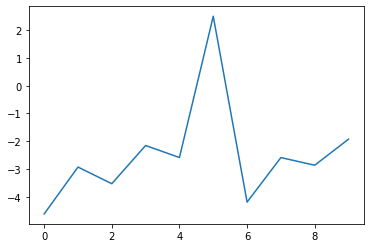

In [433]:
tail = post._ratios[((0,),)].tail.unet
head = post._ratios[((0,),)].head
f = head(dict(x = torch.tensor(obs0['x']).unsqueeze(0).float().cuda()))
tt = tail(f)[0,:,1].cpu().detach().numpy()
#params = torch.ones(1, NRES).cuda()
#plt.plot((tail(f, params)).cpu().detach().numpy()[0])
plt.plot(tt)

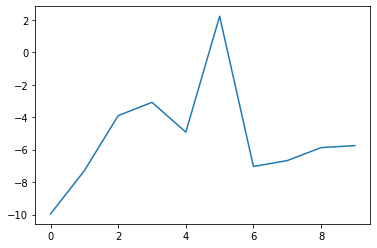

In [388]:
tail = post._ratios[((0,),)].tail.tailtail
head = post._ratios[((0,),)].head
f = head(dict(x = torch.tensor(obs0['x']).unsqueeze(0).float().cuda()))
params = torch.ones(1, NRES).cuda()
plt.plot((tail(f, params)).cpu().detach().numpy()[0])

In [194]:
v0 = np.zeros(N) + 0.5
obs0 = noise(model(v0), v0)
samples = post.sample(100000, obs0)

/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 100 and the array at index 1000 has size 0

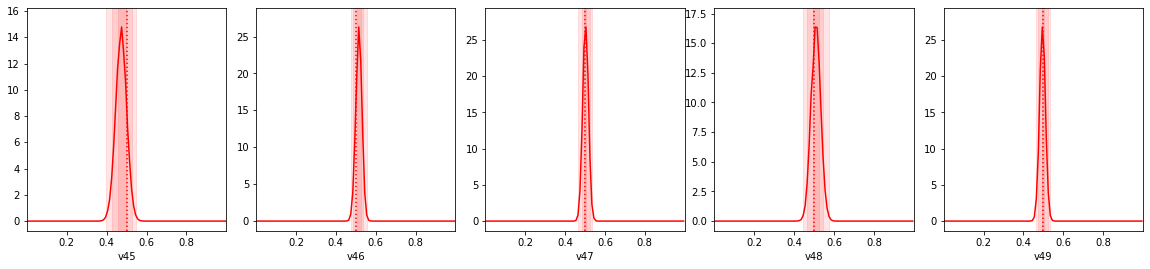

In [418]:
fig, diag = swyft.plot_1d(samples, range(45, 50), bins = 100, figsize=(20, 4), truth = v0, color='r', contours = True)